In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Online Learning Applications/Project

Mounted at /gdrive
/gdrive/My Drive/Online Learning Applications/Project


## Environment

In [ ]:
import numpy as np

In [ ]:
class Environment_Multiple_Contexts():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm and for every class (size: |classes|x|arms|)
    self.bids = bids                                                # bids
    self.average_number_of_clicks = average_number_of_clicks        # curves of average number of clicks(y = f(bids)), one for each class
    self.average_cum_daily_cost = average_cum_daily_cost            # curves of cumulative daily cost (y = g(bids)), one for each class
    self.noise_clicks = noise_clicks                                # gaussian noises for the average number of clicks sampling, one for each class
    self.noise_cost = noise_cost                                    # gaussian noises for the cumulative daily cost sampling, one for each class

  # daily rewards (given a class "i")
  def bidding_round(self, pulled_bid, i):
    clicks = int(np.random.normal(self.average_number_of_clicks[i](self.bids[pulled_bid]),self.noise_clicks[i]))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost[i](self.bids[pulled_bid]),self.noise_cost[i])                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0
    return reward_click, reward_cost

  # pricing rewards (given a class "i")
  def pricing_round(self, pulled_price, i):
    reward_price = np.random.binomial(1,self.probabilities[i][pulled_price])                         # number of people that buy once they clicked
    return reward_price

## Pricing

In [ ]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    pulled_arm = int(pulled_arm)
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [ ]:
class TS_Pricing_Learner(Learner): # Thompson-Sampling (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                    # number of prices
    self.beta_parameters = np.ones((n_arms,2))  # parameters of beta distributions
    self.prices = prices                        # prices (array)

    #self.empirical_means = np.zeros(n_arms)

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    sampled = np.random.beta(self.beta_parameters[:,0],self.beta_parameters[:,1])*self.prices
    idx = np.argmax(sampled)
    #return idx, sampled[idx]
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    pulled_arm = int(pulled_arm)
    self.update_observations(pulled_arm,reward*self.prices[pulled_arm])
    self.beta_parameters[pulled_arm,0] = self.beta_parameters[pulled_arm,0] + reward
    self.beta_parameters[pulled_arm,1] = self.beta_parameters[pulled_arm,1] + 1 - reward

    #self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])

  # given some records, it initializes the learner's relevant parameters
  # REVIEW: reimplement better
  def initialize_learner(self, collected_features):
    for features in collected_features:
      self.update(features[0], features[1])



In [ ]:
class UCB_Pricing_Learner(Learner): # UCB1 (reward: number of conversions; actual_reward:  price*conversion_rate)
  def __init__(self,n_arms,prices):
    super().__init__(n_arms)                              # number of arms/prices
    self.empirical_means = np.zeros(n_arms)               # mean reward for each arm (conversion rate)
    self.confidence = np.zeros(n_arms)                    # confidence bound for each arm
    self.prices = prices                                  # prices (array)

  def pull_arm(self):
    if(self.t < self.n_arms):
      #return self.t, 1
      return self.t
    upper_bound = self.empirical_means + self.confidence
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    #return pulled_arm, upper_bound[pulled_arm]
    #return pulled_arm, np.max(self.empirical_means)
    #return pulled_arm, self.empirical_means[pulled_arm]
    return pulled_arm

  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward*self.prices[pulled_arm])
    self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm]*(len(self.rewards_per_arm[pulled_arm]) - 1) + reward*self.prices[pulled_arm] ) / len(self.rewards_per_arm[pulled_arm])
    for a in range(self.n_arms):
      self.confidence[a] = self.prices[a]*np.sqrt(2*np.log(self.t)/len(self.rewards_per_arm[a])) if len(self.rewards_per_arm[a]) > 0 else 1e3

## Advertising

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [ ]:
class GPTS_Learner(Learner):
  # constructor takes as input the number arms (bids), intializes to 0 their means and to an aye their standard deviation; we also need to store the arm that we pull at each round to fot the GPs
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms)
    self.arms = arms
    self.means_clicks = np.ones(self.n_arms) * 1e3
    self.means_costs = np.ones(self.n_arms) * 1e3
    self.sigmas_clicks = np.ones(self.n_arms)
    self.sigmas_costs = np.ones(self.n_arms)
    self.pulled_arms = []
    self.collected_clicks = np.array([])
    self.collected_costs = np.array([])
    self.normalize_y = normalize_y
    self.n_restarts_optimizer = n_restarts_optimizer
    # we initialize the parameters of the kernel and the two GPs
    if self.normalize_y:
      self.kernel_clicks = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
      self.kernel_costs = C(2000.,(1000.,5000.)) * RBF(0.3,(0.01,0.6)) # for normalized
      #self.kernel_clicks = C(1,(1e-7,1e7)) * RBF(1,(1e-7,1e7))
      #self.kernel_costs = C(1, (1e-7,1e7)) * RBF(1,(1e-7,1e7))
    else:
      self.kernel_clicks = C(1,(1e3,1e4)) * RBF(1,(0.1,1))
      self.kernel_costs = C(1, (1e3,1e4)) * RBF(1,(0.1,1))
      #self.kernel_clicks = C(2500,(2000,3000)) * RBF(1,(0.75,0.85))
      #self.kernel_costs = C(2500, (2000,3000)) * RBF(1,(0.75,0.85))
    self.gp_clicks = GaussianProcessRegressor(kernel = self.kernel_clicks, alpha = alpha_clicks**2, normalize_y = self.normalize_y, n_restarts_optimizer = self.n_restarts_optimizer)
    self.gp_costs = GaussianProcessRegressor(kernel = self.kernel_costs, alpha = alpha_costs**2, normalize_y = self.normalize_y, n_restarts_optimizer = self.n_restarts_optimizer)
    self.plot = plot
    self.step = step
    self.step_delay = step_delay

  # we also need to update the value of the least pulled arm (reward[0]: n_clicks, reward[1]: costs)
  def update_observations(self, arm_idx, reward):
    arm_idx = int(arm_idx)
    super().update_observations(arm_idx, reward)
    self.pulled_arms.append(self.arms[arm_idx])

  # update the GP estimations and consequently the means and sigmas of each arm
  def update_model(self):
    # trining inputs and targets
    if self.t < self.step_delay or not(self.t % self.step):
      x = np.atleast_2d(self.pulled_arms).T
      y_clicks = self.collected_clicks
      y_costs = self.collected_costs
      # fit the GP
      if len(y_clicks) > 1:
        self.gp_clicks.fit(x,y_clicks)
        self.gp_costs.fit(x,y_costs)
        # update values of means and sigmas with the new predictions
        self.means_clicks, self.sigmas_clicks = self.gp_clicks.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.means_costs, self.sigmas_costs = self.gp_costs.predict(np.atleast_2d(self.arms).T, return_std = True)
        self.sigmas_clicks = np.maximum(self.sigmas_clicks, 1e-2)
        self.sigmas_costs = np.maximum(self.sigmas_costs, 1e-2)

      if self.plot:
        plt.figure()
        plt.title("Clicks:" + str(self.t))
        #plt.plot(self.arms, clicks(self.arms), 'r:', label = r'$n(x)$')
        plt.plot(x.ravel(), y_clicks.ravel(), 'ro', label = u'Observed Clicks')
        plt.plot(self.arms, self.means_clicks, 'b-', label = u'Predicted Clicks')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_clicks - 1.96 * self.sigmas_clicks , (self.means_clicks + 1.96 * self.sigmas_clicks)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$n(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

        plt.figure()
        plt.title("Costs:" + str(self.t))
        #plt.plot(self.arms, costs(self.arms), 'r:', label = r'$c(x)$')
        plt.plot(x.ravel(), y_costs.ravel(), 'ro', label = u'Observed Costs')
        plt.plot(self.arms, self.means_costs, 'b-', label = u'Predicted Costs')
        plt.fill(np.concatenate([self.arms,self.arms[::-1]]),
                np.concatenate([self.means_costs - 1.96 * self.sigmas_costs , (self.means_costs + 1.96 * self.sigmas_costs)[::-1]]),
                alpha = .5, fc = 'b', ec = 'None', label = '95% conf interval')
        plt.xlabel('$x')
        plt.ylabel('$c(x)$')
        plt.legend(loc = 'lower right')
        plt.show()

  # functions that calls the functions implemented above (reward[0]: n_clicks, reward[1]: costs)
  def update(self, pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward)
    self.collected_clicks = np.append(self.collected_clicks,reward[0])
    self.collected_costs = np.append(self.collected_costs,reward[1])
    self.update_model()

  # function in which the learner chooses the arm to pull at each round
  def pull_arm(self):
    # returns index of the maximum value drawn from the arm normal distribution
    samples = np.random.normal(self.means_clicks - self.means_costs, np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2))
    return np.argmax(samples)

  '''
  # given some records and the current time iteration, it initializes the learner's relevant parameters (REVIEW: curr_time)
  def initialize_learner(self, collected_features, curr_time):
    # get the bids for which we actually have data
    unique_bids = np.unique(collected_features[:,2])
    # for every one of these bids
    for bid in unique_bids:
      for t in range(curr_time):
        # mask the corresponding recorded data
        aux = collected_features[(collected_features[:,2]==bid)*(collected_features[:,4]==t),:]
        # recover the amount of clicks by counting the users
        clicks = aux.shape[0]
        if clicks > 0:
        # recover the costs by summing the unitary cost of each user (recovered as costs/clicks during the simulations)
          costs = np.sum(aux[:,3],axis=0)
          self.update_observations(bid,[clicks,costs])
          self.collected_clicks = np.append(self.collected_clicks,clicks)
          self.collected_costs = np.append(self.collected_costs,costs)
    # set current time index
    self.t = curr_time
    # compute the means and stds needed for the next call of pull_arm()
    self.update_model()


  # given some records and the current time iteration, it initializes the learner's relevant parameters (REVIEW: curr_time)
  def initialize_learner(self, collected_features, curr_time):
    # get the bids for which we actually have data
    unique_bids = np.unique(collected_features[:,2])
    # for every one of these bids
    for bid in unique_bids:
      # mask the corresponding recorded data
      aux = collected_features[(collected_features[:,2]==bid),:]
      # recover the amount of clicks by counting the users
      clicks = aux.shape[0]
      # recover the costs by summing the unitary cost of each user (recovered as costs/clicks during the simulations)
      costs = np.sum(aux[:,3],axis=0)
      # update the GP
      self.update_observations(bid,[clicks,costs])
      self.collected_clicks = np.append(self.collected_clicks,clicks)
      self.collected_costs = np.append(self.collected_costs,costs)
    # set current time index
    self.t = curr_time
    # compute the means and stds needed for the next call of pull_arm()
    self.update_model()
  '''

  def initialize_learner(self, collected_cc, curr_time): # [x1, x2, pulled_bid, clicks, costs, t]


    unique_x1 = np.unique(collected_cc[:,0])
    xx1 = len(unique_x1) - 1
    unique_x2 = np.unique(collected_cc[:,1])
    xx2 = len(unique_x2) - 1

    for t in range(curr_time):
      temp_cc = collected_cc[collected_cc[:,-1]==t,:]
      for bid in np.unique(temp_cc[:,2]):
        temp_2_cc = temp_cc[temp_cc[:,2] == bid,:]
        if temp_2_cc.shape[0] > (xx1 + xx2):
          clicks = np.sum(temp_cc[temp_cc[:,2] == bid,3])
          costs = np.sum(temp_cc[temp_cc[:,2] == bid,4])
          self.update_observations(int(bid),[clicks,costs])
          self.collected_clicks = np.append(self.collected_clicks,clicks)
          self.collected_costs = np.append(self.collected_costs,costs)
    self.t = curr_time
    self.update_model()

    # NB: alternative -> mean initialization over all the bids we have "full data" for

    '''
    for i in range(collected_cc.shape[0]):
      self.update_observations(int(collected_cc[i,0]),[collected_cc[i,1],collected_cc[i,2]])
      self.collected_clicks = np.append(self.collected_clicks,collected_cc[i,1])
      self.collected_costs = np.append(self.collected_costs,collected_cc[i,2])
    self.t = curr_time
    self.update_model()
    '''


  def set_alpha(self, new_alpha_clicks, new_alpha_costs):
    self.gp_clicks = GaussianProcessRegressor(kernel = self.kernel_clicks, alpha = new_alpha_clicks**2, normalize_y = self.normalize_y, n_restarts_optimizer = self.n_restarts_optimizer)
    self.gp_costs = GaussianProcessRegressor(kernel = self.kernel_costs, alpha = new_alpha_costs**2, normalize_y = self.normalize_y, n_restarts_optimizer = self.n_restarts_optimizer)

In [ ]:
class GPUCB_Learner(GPTS_Learner):
  def __init__(self, n_arms, arms, alpha_clicks, alpha_costs, normalize_y = False, step = 1, step_delay = 366, n_restarts_optimizer = 0, plot = False):
    super().__init__(n_arms, arms, alpha_clicks, alpha_costs, normalize_y, step, step_delay, n_restarts_optimizer, plot)

  # returns index of the maximum UCB from the arm normal distribution (coefficient for CI of order 1-1/T: 3.0)
  def pull_arm(self):
    upper_bound = self.means_clicks - self.means_costs + 3.0*np.sqrt(self.sigmas_clicks**2 + self.sigmas_costs**2)
    pulled_arm = np.random.choice(np.where(upper_bound == upper_bound.max())[0])
    return pulled_arm

## Simulation

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# generic
T = 365                               # horizon of experiment
n_experiments = 10                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

We work with 3 different classes:
-  C1: x1 = 1, x2 = free
-   C2: x1 = 0, x2 = 1
-   C3: x1 = 0, x2 = 0

that present different probabilities/curves over the same prices/bids. The distribution of users is uniform over the 3 classes (1/3 each).

In [ ]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.36,0.3,0.257,0.313,0.2],
              [0.5,0.3,0.257,0.225,0.2],
              [0.36,0.3,0.257,0.225,0.278]])             # bernoulli distributions for the reward functions
opt_rate = [p[0][np.argmax(p[0]*prices)],
            p[1][np.argmax(p[1]*prices)],
            p[2][np.argmax(p[2]*prices)]]                 # optimal arm

for i in range(0,3):
    print("Pricing (optimal price) context ", str(i))
    print("idx: " + str(np.argmax(p[i]*prices)) + "  price: " + str(prices[np.argmax(p[i]*prices)]) + "  rate: " + str(opt_rate[i]) + "  price*rate: " + str(opt_rate[i]*prices[np.argmax(p[i]*prices)]))

Pricing (optimal price) context  0
idx: 3  price: 8  rate: 0.313  price*rate: 2.504
Pricing (optimal price) context  1
idx: 0  price: 5  rate: 0.5  price*rate: 2.5
Pricing (optimal price) context  2
idx: 4  price: 9  rate: 0.278  price*rate: 2.5020000000000002


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768
Advertising (optimal bid):
idx: 59  bid: 0.595959595959596  clicks-costs: 9.57619827197513
Advertising (optimal bid):
idx: 57  bid: 0.5757575757575758  clicks-costs: 33.832338920201714


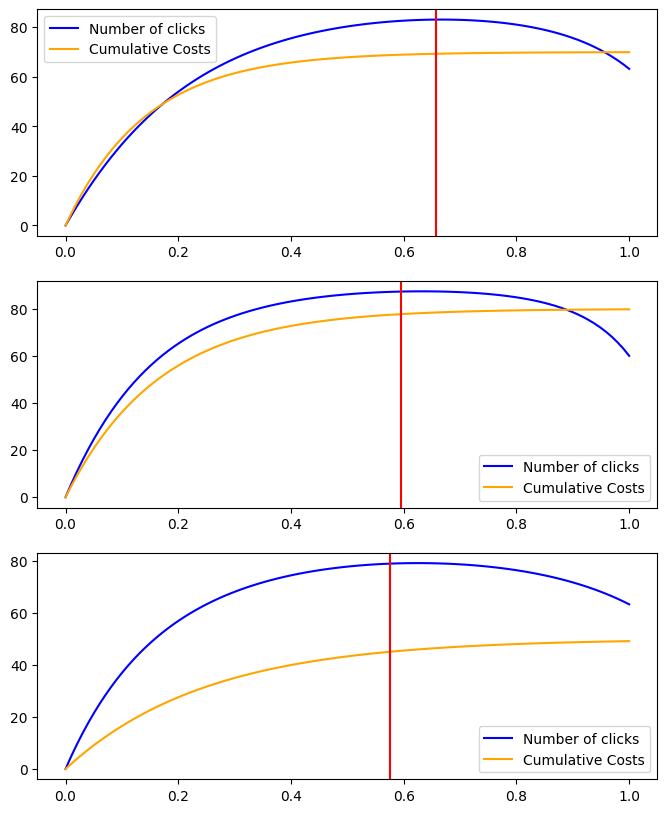

In [ ]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = [3, 2.5, 3]
sigma_costs = [3, 2.5, 3]

params_clicks = [[100, 4, 3, 3],
                 [95,  6, 5, 3],
                 [100, 5, 4, 2]]
params_costs = [[70, 7],
                [80, 6],
                [50, 4]]
def clicks(x, params=[100, 4, 3, 3]):
  return params[0] * (1.0 - np.exp(-params[1]*x+params[2]*x**params[3]))

def costs(x, params=[70, 7]):
  return params[0] * (1.0 - np.exp(-params[1]*x))


opt_bid = np.zeros(3)
for i in range(0,3):
    opt_bid[i] = bids[np.argmax(opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(bids, params_clicks[i])-costs(bids, params_costs[i]))]

fig, ax = plt.subplots(3, figsize=(8,10))
for i in range(0, 3):
    ax[i].plot(bids,clicks(bids, params_clicks[i]),'blue',bids, costs(bids, params_costs[i]),'orange')
    ax[i].legend(["Number of clicks", "Cumulative Costs"])
    ax[i].axvline(opt_bid[i],c='red')
    print("Advertising (optimal bid):")
    print("idx: " + str(np.argmax(opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(bids, params_clicks[i])-costs(bids, params_costs[i]))) + "  bid: " + str(opt_bid[i]) + "  clicks-costs: " + str(clicks(opt_bid[i], params_clicks[i])-costs(opt_bid[i], params_costs[i])))

In [ ]:
# Function wrapper to be able to pass to environment
def clicks1(x):
    return clicks(x, params_clicks[0])
def clicks2(x):
    return clicks(x, params_clicks[1])
def clicks3(x):
    return clicks(x, params_clicks[2])

In [ ]:
# Function wrapper to be able to pass to environment
def costs1(x):
    return costs(x, params_costs[0])
def costs2(x):
    return costs(x, params_costs[1])
def costs3(x):
    return costs(x, params_costs[2])

In [ ]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [ ]:
n_experiments = 100
T=365

# GP debug
n_restarts_optimizer = 0
step = 10
plot = False
normalize_y = False



gpts_rewards_per_experiment = []
gpucb_rewards_per_experiment = []


for e in tqdm(range(0,n_experiments)):  # cycle on experiments

  # environment setup ()
  env = Environment_Multiple_Contexts(n_arms = n_prices,
                                        probabilities = p,
                                        bids = bids,
                                        average_number_of_clicks = [clicks1, clicks2, clicks3],
                                        average_cum_daily_cost = [costs1, costs2, costs3],
                                        noise_clicks = sigma_clicks,
                                        noise_cost = sigma_costs)


  pricing_learner_gpts = UCB_Pricing_Learner(n_arms = n_prices,
                                            prices = prices)
  pricing_learner_gpucb = UCB_Pricing_Learner(n_arms = n_prices,
                                            prices = prices)
  gpts_learner = GPTS_Learner(n_arms = n_bids,
                              arms = bids,
                              alpha_clicks = np.sqrt(np.sum((np.array(sigma_clicks)**2))),
                              alpha_costs = np.sqrt(np.sum((np.array(sigma_costs)**2))),
                              step = step,
                              normalize_y = normalize_y,
                              n_restarts_optimizer = n_restarts_optimizer,
                              plot = plot,
                              step_delay = 0)
  gpucb_learner = GPUCB_Learner(n_arms = n_bids,
                                arms = bids,
                                alpha_clicks = np.sqrt(np.sum((np.array(sigma_clicks)**2))),
                                alpha_costs = np.sqrt(np.sum((np.array(sigma_costs)**2))),
                                step = step,
                                normalize_y = normalize_y,
                                plot = plot,
                                n_restarts_optimizer = n_restarts_optimizer,
                                step_delay = 0)

  gpts_daily_pricing_reward = np.array([])
  gpucb_daily_pricing_reward = np.array([])


  for t in range(0, T): # cycle on days


    # GPTS
    pulled_bid_ts = gpts_learner.pull_arm()

    # initialization of temporary variable for storing the total amount of clicks in the context
    reward_click_ts = 0
    # initialization of temporary variable for storing the total daily costs of the contexts
    reward_cost_ts = 0
    # list for temporarely storing the observed users (will be used for a shuffling so that we do not to induce an order bias in the pricing learner)
    pulled_reward_price_arr = []


    for env_idx in range(3):

        # observe the daily clicks and costs for this class
        reward_click_ts_, reward_cost_ts_ = env.bidding_round(pulled_bid_ts, env_idx)
        # update the total daily clicks and costs of the context
        temp_click_ts = reward_click_ts_
        temp_cost_ts = reward_cost_ts_
        reward_click_ts += temp_click_ts
        reward_cost_ts += temp_cost_ts

        for click_idx in range(temp_click_ts):

          # pull a price and observe the corresponding reward  (NB: for now we are updating the pricing learner only at the end of the day)
          pulled_price = pricing_learner_gpts.pull_arm()
          reward_price = env.pricing_round(pulled_price, env_idx)
          # store the user information in the temporary list (NB: the last term for each user is its unitary cost)
          pulled_reward_price_arr.append((pulled_price, reward_price))

    # shuffle the observed users
    np.random.shuffle(pulled_reward_price_arr)

    # for each user in the shuffled users
    for arr in pulled_reward_price_arr:

      # decouple its recorded values
      pulled_price, reward_price = arr

      # update the pricing learner
      pricing_learner_gpts.update(pulled_price, reward_price)

    gpts_learner.update(pulled_bid_ts, [reward_click_ts,reward_cost_ts])
    gpts_daily_pricing_reward = np.append(gpts_daily_pricing_reward,(reward_click_ts>0)*np.sum(pricing_learner_gpts.collected_rewards[-reward_click_ts:]))



    # GPUCB
    pulled_bid_ucb = gpucb_learner.pull_arm()

    # initialization of temporary variable for storing the total amount of clicks in the context
    reward_click_ucb = 0
    # initialization of temporary variable for storing the total daily costs of the contexts
    reward_cost_ucb = 0
    # list for temporarely storing the observed users (will be used for a shuffling so that we do not to induce an order bias in the pricing learner)
    pulled_reward_price_arr = []


    for env_idx in range(3):

        # observe the daily clicks and costs for this class
        reward_click_ucb_, reward_cost_ucb_ = env.bidding_round(pulled_bid_ucb, env_idx)
        # update the total daily clicks and costs of the context
        temp_click_ucb = reward_click_ucb_
        temp_cost_ucb = reward_cost_ucb_
        reward_click_ucb += temp_click_ucb
        reward_cost_ucb += temp_cost_ucb

        for click_idx in range(temp_click_ucb):

          # pull a price and observe the corresponding reward  (NB: for now we are updating the pricing learner only at the end of the day)
          pulled_price = pricing_learner_gpucb.pull_arm()
          reward_price = env.pricing_round(pulled_price, env_idx)
          # store the user information in the temporary list (NB: the last term for each user is its unitary cost)
          pulled_reward_price_arr.append((pulled_price, reward_price))

    # shuffle the observed users
    np.random.shuffle(pulled_reward_price_arr)

    # for each user in the shuffled users
    for arr in pulled_reward_price_arr:

      # decouple its recorded values
      pulled_price, reward_price = arr

      # update the pricing learner
      pricing_learner_gpucb.update(pulled_price, reward_price)

    gpucb_learner.update(pulled_bid_ucb, [reward_click_ucb,reward_cost_ucb])
    gpucb_daily_pricing_reward = np.append(gpucb_daily_pricing_reward,(reward_click_ucb>0)*np.sum(pricing_learner_gpucb.collected_rewards[-reward_click_ucb:]))

  gpts_rewards_per_experiment.append(gpts_daily_pricing_reward - gpts_learner.collected_costs)
  gpucb_rewards_per_experiment.append(gpucb_daily_pricing_reward - gpucb_learner.collected_costs)


100%|██████████| 100/100 [59:38<00:00, 35.79s/it]


<function matplotlib.pyplot.show(close=None, block=None)>

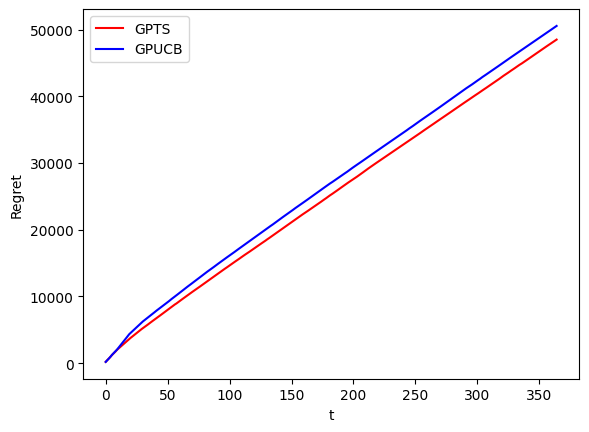

In [ ]:
# optimum value computed as the sum of the optimal values for the 3 classes of users
opt = np.sum([opt_rate[i]*prices[np.argmax(p[i]*prices)]*clicks(opt_bid[i], params_clicks[i]) - costs(opt_bid[i], params_costs[i]) for i in range(3)])

# plot the results
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis = 0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gpucb_rewards_per_experiment, axis = 0)), 'b')
plt.legend(["GPTS","GPUCB"])
plt.show

In [ ]:
np.savetxt('part4_3_gpts.txt',gpts_rewards_per_experiment)
np.savetxt('part4_3_gpucb.txt',gpucb_rewards_per_experiment)

In [ ]:
#gpts_rewards_per_experiment = np.loadtxt('part4_3_gpts.txt')
#gpucb_rewards_per_experiment = np.loadtxt('part4_3_gpucb.txt')

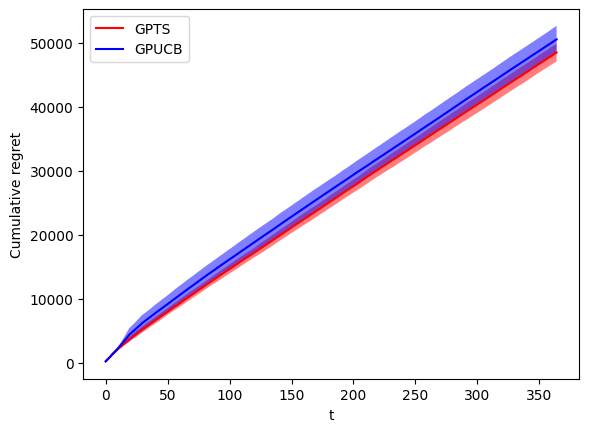

In [ ]:
plt.figure()
plt.ylabel("Cumulative regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - gpts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(opt - gpucb_rewards_per_experiment, axis=0)), 'b')

time = range(0, T)
ts_std = np.std(np.cumsum(opt - gpts_rewards_per_experiment, axis=1), axis=0)
ts_metric= np.mean(np.cumsum(opt - gpts_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(np.cumsum(opt - gpucb_rewards_per_experiment, axis=1), axis=0)
ucb_metric = np.mean(np.cumsum(opt - gpucb_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["GPTS", "GPUCB"])

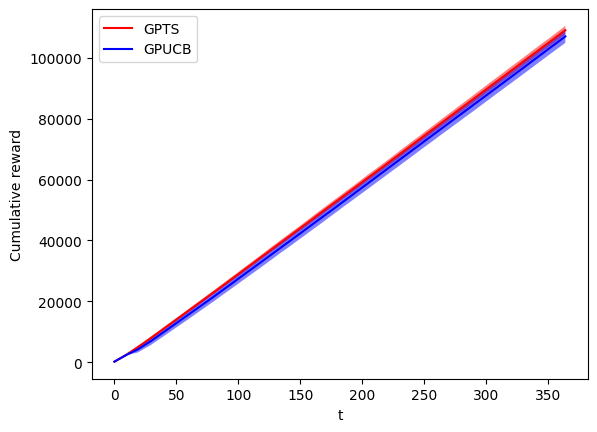

In [ ]:
plt.figure()
plt.ylabel("Cumulative reward")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(gpts_rewards_per_experiment, axis=0)), 'r')
plt.plot(np.cumsum(np.mean(gpucb_rewards_per_experiment, axis=0)), 'b')

time = range(0, T)
ts_std = np.std(np.cumsum(gpts_rewards_per_experiment, axis=1), axis=0)
ts_metric= np.mean(np.cumsum(gpts_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(np.cumsum(gpucb_rewards_per_experiment, axis=1), axis=0)
ucb_metric = np.mean(np.cumsum(gpucb_rewards_per_experiment, axis=1), axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["GPTS", "GPUCB"])

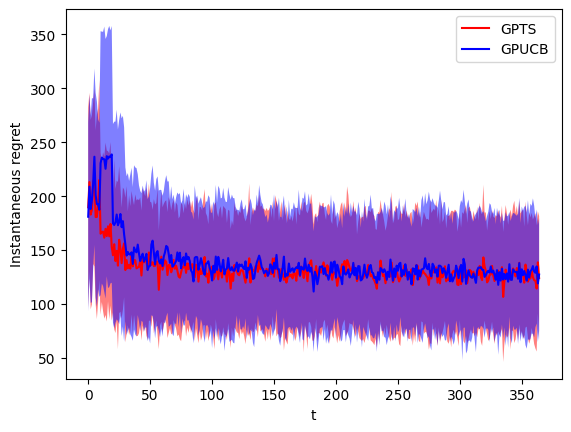

In [ ]:
plt.figure()
plt.ylabel("Instantaneous regret")
plt.xlabel("t")
plt.plot(np.mean(opt - gpts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(opt - gpucb_rewards_per_experiment, axis=0), 'b')

time = range(0, T)
ts_std = np.std(opt - gpts_rewards_per_experiment, axis=0)
ts_metric= np.mean(opt - gpts_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(opt - gpucb_rewards_per_experiment, axis=0)
ucb_metric = np.mean(opt - gpucb_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["GPTS", "GPUCB"])

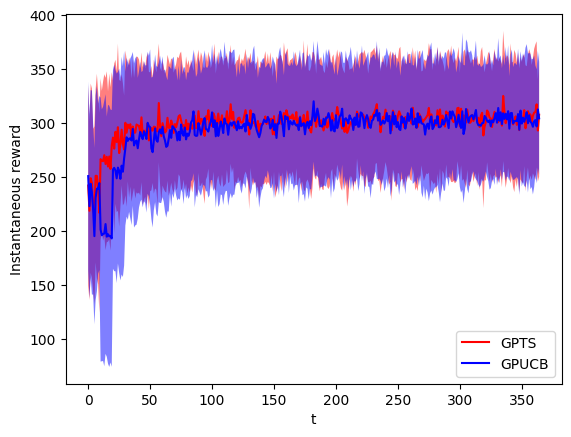

In [ ]:
plt.figure()
plt.ylabel("Instantaneous reward")
plt.xlabel("t")
plt.plot(np.mean(gpts_rewards_per_experiment, axis=0), 'r')
plt.plot(np.mean(gpucb_rewards_per_experiment, axis=0), 'b')

time = range(0, T)
ts_std = np.std(gpts_rewards_per_experiment, axis=0)
ts_metric= np.mean(gpts_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ts_metric - ts_std, (ts_metric + ts_std)[::-1]]),
         alpha=.5, fc='r', ec=None, label='standard deviation')

ucb_std = np.std(gpucb_rewards_per_experiment, axis=0)
ucb_metric = np.mean(gpucb_rewards_per_experiment, axis=0)
plt.fill(np.concatenate([time, time[::-1]]),
         np.concatenate([ucb_metric - ucb_std, (ucb_metric+ ucb_std)[::-1]]),
         alpha=.5, fc='b', ec=None, label='standard deviation')

plt.legend(["GPTS", "GPUCB"])